In [1]:
using Eirene
using MAT
using LinearAlgebra
using Statistics
using Printf
using PyPlot
using Plotly
using ORCA
using Distributions
using Random
using WebIO, IJulia
#WebIO.install_jupyter_labextension()

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-16874102984516899934\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-8366786256385089080\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-16874102984516899934\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

## WSBM Generator

### SBM version

In [2]:
function generate_clusters(n=100,pi_vector=[0.3,0.4,0.3])
    clusters_splits=round.(Int,cumsum(n*pi_vector))
    k = size(pi_vector)[1]
    c = zeros(Int8,n) 
    for k_ind in collect(0:k-2)
        c[clusters_splits[k_ind+1]:clusters_splits[k_ind+2]].=k_ind+1
    end
    return c
end
function generate_sbm_adj(n,pi_vector,theta_in,theta_out)
    c=generate_clusters(n,pi_vector)
    Adj=zeros(Int8,n,n)
    for i in collect(1:n-1)
        for j in collect(i+1:n)
            if c[i]==c[j]
                Adj[i,j]=round.(Int,rand((0:100))<100*theta_in)
                Adj[j,i]=Adj[i,j]
                else
                Adj[i,j]=round.(Int,rand((0:100))<100*theta_out)
                Adj[j,i]=Adj[i,j]
            end
        end
    end
    return Adj
end

generate_sbm_adj (generic function with 1 method)

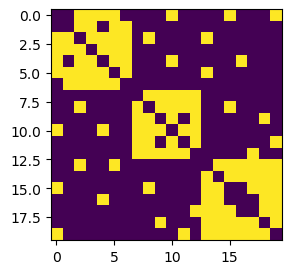

PyObject <matplotlib.image.AxesImage object at 0x16efde910>

In [5]:
Adj = generate_sbm_adj(20,[0.4,0.3, 0.3],0.9,0.1)
plt.figure(figsize=(3,3))
imshow(Adj)

### Weighted Version

Я чуть изменила функцию, добавила в конец два опциональных параметра: номер усиливаемого блока и параметр усиления - это для моделей с выделенной группой нодов. 

In [6]:
function generate_wsbm_adj(n,pi_vector,theta_in,theta_out,n_block=nothing,enh_param=nothing)
     c=generate_clusters(n,pi_vector)
     Adj=zeros(Float64,n,n)
     for i in collect(1:n-1)
        for j in collect(i+1:n)
            if c[i]==c[j]
                if n_block==nothing
                    Adj[i,j]=rand(LogitNormal(rand(Normal(theta_in),1)[1]))
                    Adj[j,i]=Adj[i,j]
                else
                    if c[i]==n_block-1
                        Adj[i,j]=rand(LogitNormal(rand(Normal(theta_in),1)[1]))*enh_param
                        Adj[j,i]=Adj[i,j]
                    else
                        Adj[i,j]=rand(LogitNormal(rand(Normal(theta_in),1)[1]))
                        Adj[j,i]=Adj[i,j]
                    end
                end
            else
                 Adj[i,j]=rand(LogitNormal(rand(Normal(theta_out),1)[1]))
                 Adj[j,i]=Adj[i,j]
            end
        end
    end
    Adj[diagind(Adj)].= 1
    return Adj
end
                    

generate_wsbm_adj (generic function with 3 methods)

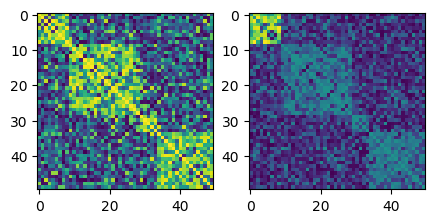

PyObject <matplotlib.image.AxesImage object at 0x16f37a810>

In [7]:
wAdj = generate_wsbm_adj(50,[0.2,0.4,0.1,0.3],1,-1)
wAdj_enh = generate_wsbm_adj(50,[0.2,0.4,0.1,0.3],1,-1,1,2)
plt.figure(figsize=(5,5))
subplot(121); imshow(wAdj)
subplot(122); imshow(wAdj_enh)

In [8]:
function random_permute(matrix)
    n=size(matrix)[1]
    order=randperm(n)
    permuted=zeros(Float64,n,n)
    for i in collect(1:n-1)
            for j in collect(i+1:n)
                permuted[i,j]=matrix[order[i],order[j]]
                permuted[j,i]=matrix[order[j],order[i]]
            end
        end
    return order, permuted
end             

random_permute (generic function with 1 method)

In [9]:
function inverse_permute(order,permuted)
    n=size(permuted)[1]
    new_order=sortperm(order)
    inverse=zeros(Float64,n,n)
    for i in collect(1:n-1)
        for j in collect(i+1:n)
            inverse[i,j] = permuted[new_order[i],new_order[j]]
            inverse[j,i] = permuted[new_order[j],new_order[i]]
        end
    end
    return inverse
end         

inverse_permute (generic function with 1 method)

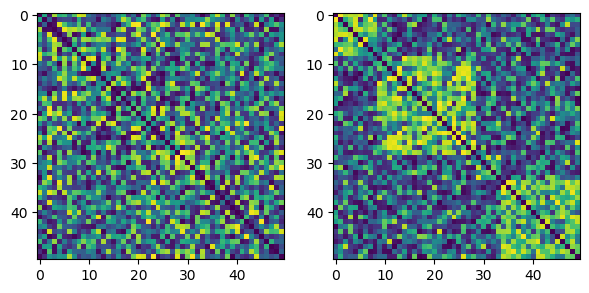

PyObject <matplotlib.image.AxesImage object at 0x16132dc50>

In [8]:
plt.figure(figsize = (7,7))
wAdj = generate_wsbm_adj(50,[0.2,0.4,0.1,0.3],1,-1)
order,permuted =random_permute(wAdj)
subplot(121); imshow(permuted)
subplot(122); imshow(inverse_permute(order, permuted))

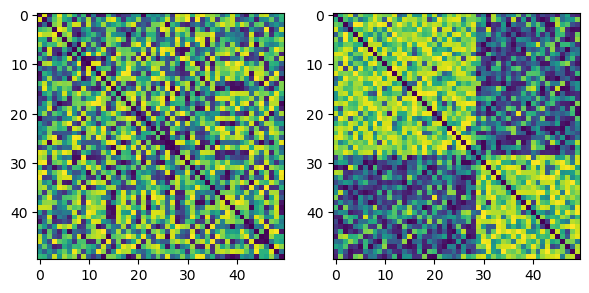

PyObject <matplotlib.image.AxesImage object at 0x16f73ca90>

In [10]:
plt.figure(figsize = (7,7))
number_of_nodes=50
pi_vector=[0.6,0.4]
theta_in=1.5
theta_out=-1
wAdj = generate_wsbm_adj(number_of_nodes,pi_vector,theta_in,theta_out)
order,permuted =random_permute(wAdj)
subplot(121); imshow(permuted)
subplot(122); imshow(inverse_permute(order, permuted))

## TDA part

In [11]:
function get_distance(matrix)
   
    distC = ((matrix.-1).*(-1)).^0.5;
    distC[diagind(distC)].= 0; 
    return distC
end 
function TDA(matrix)
    dist_mat=get_distance(matrix)
    C=eirene(dist_mat,maxdim=2)
    return C
end

TDA (generic function with 1 method)

In [12]:
number_of_nodes=20
pi_vector=[0.4,0.3,0.3]
theta_in=3
theta_out=-1
wAdj=generate_wsbm_adj(number_of_nodes,pi_vector,theta_in,theta_out)
C=TDA(wAdj);
#plotbetticurve_pjs(C,dim=1)

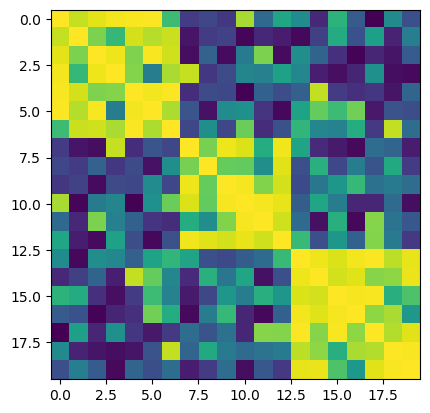

PyObject <matplotlib.image.AxesImage object at 0x16f9d1d10>

In [15]:
imshow(wAdj)

In [13]:
round.(Int,cumsum(number_of_nodes*pi_vector))

3-element Array{Int64,1}:
  8
 14
 20

In [14]:
wAdj

20×20 Array{Float64,2}:
 1.0         0.91417    0.958874   …  0.00440251  0.480118   0.249145
 0.91417     1.0        0.802933      0.566492    0.105136   0.431737
 0.958874    0.802933   1.0           0.112516    0.0605931  0.293581
 0.981908    0.665598   0.975912      0.504939    0.0430231  0.027805
 0.990077    0.935771   0.806306      0.16168     0.0596669  0.330398
 0.992326    0.889343   0.991087   …  0.0739655   0.258974   0.243843
 0.686194    0.919766   0.929698      0.169237    0.908798   0.362082
 0.175637    0.0596054  0.040082      0.360343    0.329493   0.0840793
 0.217139    0.176987   0.317649      0.26266     0.608404   0.179831
 0.164019    0.198815   0.0338112     0.375936    0.410349   0.361784
 0.870129    0.017848   0.412499   …  0.110803    0.350583   0.0403917
 0.34559     0.114163   0.804631      0.818515    0.383194   0.273157
 0.594845    0.0805417  0.0341047     0.815296    0.41756    0.171432
 0.484598    0.0267044  0.495038      0.995791    0.899602   0.9

In [55]:
order,permuted =random_permute(wAdj)
C=TDA(permuted);
plotbetticurve_pjs(C,dim=0)

data: [
  "scatter with fields line, mode, type, x, and y"
]

layout: "layout with fields height, hovermode, margin, scene, showlegend, and width"

In [76]:
plotpersistencediagram_pjs(C, dim=2)

data: [
  "scatter with fields hoverinfo, marker, mode, text, textfont, textposition, type, x, and y",
  "scatter with fields hoverinfo, marker, mode, text, textfont, textposition, type, x, and y"
]

layout: "layout with fields height, hovermode, margin, scene, showlegend, and width"

In [13]:
number_of_nodes=40
pi_vector=[0.3,0.1,0.2,0.4]
theta_in=3
theta_out=-1 
wAdj=generate_wsbm_adj(number_of_nodes,pi_vector,theta_in,theta_out)
plt.figure(figsize=(3,3))
imshow(wAdj)
wAdj_name=string(number_of_nodes,"_nodes_",size(pi_vector)[1],"_blocks")
wAdj_distance=get_distance(wAdj)
C=TDA(wAdj_distance,wAdj_name)

MethodError: MethodError: no method matching TDA(::Array{Float64,2}, ::String)
Closest candidates are:
  TDA(::Any) at In[10]:8

In [21]:
plotbarcode_pjs(C,dim=2)

data: [
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, name, type, x, and y"
]

layout: "layout with fields margin, xaxis, and yaxis"

In [15]:
function print_all_reprs(C, dim)
    b=barcode(C,dim=dim)
    num=size(b)[1]
    intervals=[string("Dimension: ",dim,"\n")]
    println("Printing",intervals[1])
    for j in collect(1:size(b)[1])
        ints=@sprintf "[%.3f, %.3f): " b[j,1] b[j,2]
        repr=classrep(C, class=j, dim=dim)
        simplList=[]
        for i in collect(1:size(repr)[2])
            push!(simplList,"["*join(string.(repr[:,i]),",")*"]")
        end
        push!(intervals, string(ints, join(simplList,"+")))
    end
    return sort(intervals)
end

print_all_reprs (generic function with 1 method)

In [8]:
function write_barcode_to_file(C, filename; maxdim = 2)

    open(filename,"w") do f
        
        for dim in collect(0:maxdim)
        
            b = barcode(C, dim = dim)
            num = size(b)[1]
        
            write(f,string("Dimension: ", dim,"\n"))
            #println(string("Dimension: ", dim,"\n"))
                  
            
            for j in collect(1:num)
    
                ints = @sprintf "[%.3f, %.3f): " b[j,1] b[j,2]
                repr = classrep(C, class = j, dim = dim)
                part1 = @sprintf "[%.3f, %.3f): " b[j,1] b[j,2]
            
                simplList = []
                for i in collect(1:size(repr)[2]) 
                    push!(simplList,"["*join(string.(repr[:,i]),",")*"]")
                end 
            
                part2 = string(part1, join(simplList,"+"),"\n")
                write(f,part2)
            end
        end
        
    end
end

write_barcode_to_file (generic function with 1 method)

In [13]:
join(pi_vector,'_')

"0.4_0.3_0.3"

In [23]:
filename = string("ints_",number_of_nodes,'_',join(pi_vector,'_'),'_',theta_in, theta_out, ".txt")
write_barcode_to_file(C, filename, maxdim = 2)

In [17]:
for i in collect(1:size(groups_of_models)[1])
    C=TDA(groups_of_models[i],groups_of_variable_names[i])
    #for dim in collect(0:2)
    #plotbarcode_pjs(C,dim=1)
    #savefig(string(cur_dir,"TDA_Results_Images/barcode_",groups_of_variable_names[i],"_dim",1,".png"))
    #plotbetticurve_pjs(C,dim=1)
    #savefig(string(cur_dir,"TDA_Results_Images/betti_curve_",groups_of_variable_names[i],"_dim",1,".png"))
    end
end

UndefVarError: UndefVarError: groups_of_models not defined

Старые функции для доступа к данным

In [18]:
function get_access_to_data(cur_dir, distr_name,n_blocks, n_nodes)
    folder_path=string(cur_dir,distr_name,"_Distr/")
    substr=string(distr_name,"_",n_blocks,"b_",n_nodes,"n_")
    file_path=""
    file_path_enh=""
    for i in collect(1:size(readdir(folder_path))[1])
        if occursin(substr,readdir(folder_path)[i])==true
            if occursin("enh",readdir(folder_path)[i])==false
                file_path=string(folder_path,readdir(folder_path)[i])
            else 
                file_path_enh=string(folder_path,readdir(folder_path)[i])
        end
        end
    end
    model_matrix=matread(file_path)["standard_model"]
    model_matrix_enh=matread(file_path_enh)["node_enhanced_model"]
    return model_matrix, model_matrix_enh
    end

get_access_to_data (generic function with 1 method)

In [19]:
function grouping_models(cur_dir,params_list,distr_name)
    list_of_models=[]
    list_of_models_names=[]
    for i in collect(1:size(params_list)[1])
        append!(list_of_models,get_access_to_data(cur_dir,distr_name,params_list[i][1],params_list[i][2]))
        push!(list_of_models_names, string(distr_name[1],"_",params_list[i][1],"b_",params_list[i][2],"n"))
        push!(list_of_models_names, string(distr_name[1],"_",params_list[i][1],"b_",params_list[i][2],"n_enh"))
        end
    return list_of_models,list_of_models_names
end

grouping_models (generic function with 1 method)

In [20]:
cur_dir="C:/Users/806618/TDA_model_data/";
distr_names=["Normal","Poisson","Exponential"]
params_list=[(3,5),(3,7),(4,5),(5,7),(6,5)]

groups_of_models=[]
groups_of_variable_names=[]
for distr in distr_names
    append!(groups_of_models,grouping_models(cur_dir,params_list,distr)[1])
    append!(groups_of_variable_names,grouping_models(cur_dir,params_list,distr)[2])
end

SystemError: SystemError: unable to read directory C:/Users/806618/TDA_model_data/Normal_Distr/: No such file or directory